# Data Source

In [ ]:
#!pip install yfinance
import yfinance as yf

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Import essential machine learning packages
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV,GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score,  confusion_matrix

# 1. Decicion Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier

# 3. Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Retrieve Tesla historic data
tesla = yf.Ticker("TSLA")
data = tesla.history(period="max",end="2024-12-01")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [ ]:
# Check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3631 entries, 2010-06-29 00:00:00-04:00 to 2024-11-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3631 non-null   float64
 1   High          3631 non-null   float64
 2   Low           3631 non-null   float64
 3   Close         3631 non-null   float64
 4   Volume        3631 non-null   int64  
 5   Dividends     3631 non-null   float64
 6   Stock Splits  3631 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 226.9 KB


In [ ]:
# Convert the index of the DataFrame to a datetime format for time-series analysis
data.index = pd.to_datetime(data.index)

# Set pandas to display float values with 4 decimal places for cleaner output
pd.set_option('display.float_format', lambda x: '%.4f' % x)

data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.2667,1.6667,1.1693,1.5927,281494500,0.0000,0.0000
2010-06-30 00:00:00-04:00,1.7193,2.0280,1.5533,1.5887,257806500,0.0000,0.0000
2010-07-01 00:00:00-04:00,1.6667,1.7280,1.3513,1.4640,123282000,0.0000,0.0000
2010-07-02 00:00:00-04:00,1.5333,1.5400,1.2473,1.2800,77097000,0.0000,0.0000
2010-07-06 00:00:00-04:00,1.3333,1.3333,1.0553,1.0740,103003500,0.0000,0.0000


# Data Preprocessing

## Create the binary target variable

Purposes
* Simplify modeling into a binary classification problem
* Identify “Up Opportunity” based on future stock price performance
* Select 5 future days for Signal due to active short-term trading strategies


In [ ]:
# Set own parameter
look_ahead_days = 5  # n-day look-ahead

# Calculate future returns into n-day look-ahead
data['Future_Return'] = (data['Close'].shift(-look_ahead_days) - data['Close']) / data['Close'] * 100

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Future_Return
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.2667,1.6667,1.1693,1.5927,281494500,0.0000,0.0000,-33.8636
2010-06-30 00:00:00-04:00,1.7193,2.0280,1.5533,1.5887,257806500,0.0000,0.0000,-26.7310
2010-07-01 00:00:00-04:00,1.6667,1.7280,1.3513,1.4640,123282000,0.0000,0.0000,-20.7650
2010-07-02 00:00:00-04:00,1.5333,1.5400,1.2473,1.2800,77097000,0.0000,0.0000,-11.1979
2010-07-06 00:00:00-04:00,1.3333,1.3333,1.0553,1.0740,103003500,0.0000,0.0000,12.6008
...,...,...,...,...,...,...,...,...
2024-11-22 00:00:00-05:00,341.0900,361.5300,337.7000,352.5600,89140700,0.0000,0.0000,NaN
2024-11-25 00:00:00-05:00,360.1400,361.9300,338.2000,338.5900,95890900,0.0000,0.0000,NaN
2024-11-26 00:00:00-05:00,341.0000,346.9600,335.6600,338.2300,62295900,0.0000,0.0000,NaN


In [ ]:
# Compute average future return
average_return = data['Future_Return'].mean()
average_return

1.0932790905034195

In [ ]:
 # Set Up threshold (%) to be 1.5 times the average_return
threshold_up = average_return*1.5

# Define target variable
data['Signal'] = 0  # Initialize the Signal
data.loc[data['Future_Return'] >= threshold_up, 'Signal'] = 1  # Set to 1 where Future_Return is at least threshold_up

# Drop rows where we cannot calculate Future_Return due to shifting
data.dropna(subset=['Future_Return'], inplace=True)

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Future_Return,Signal
Date,,,,,,,,,
2010-06-29 00:00:00-04:00,1.2667,1.6667,1.1693,1.5927,281494500,0.0000,0.0000,-33.8636,0
2010-06-30 00:00:00-04:00,1.7193,2.0280,1.5533,1.5887,257806500,0.0000,0.0000,-26.7310,0
2010-07-01 00:00:00-04:00,1.6667,1.7280,1.3513,1.4640,123282000,0.0000,0.0000,-20.7650,0
2010-07-02 00:00:00-04:00,1.5333,1.5400,1.2473,1.2800,77097000,0.0000,0.0000,-11.1979,0
2010-07-06 00:00:00-04:00,1.3333,1.3333,1.0553,1.0740,103003500,0.0000,0.0000,12.6008,1
...,...,...,...,...,...,...,...,...,...
2024-11-15 00:00:00-05:00,310.5700,324.6800,309.2200,320.7200,114440300,0.0000,0.0000,9.9277,1
2024-11-18 00:00:00-05:00,340.7300,348.5500,330.0100,338.7400,126547500,0.0000,0.0000,-0.0443,0
2024-11-19 00:00:00-05:00,335.7600,347.3800,332.7500,346.0000,88852500,0.0000,0.0000,-2.2457,0


## Create 6 attributes

Purposes of creating 6 features:
Daily_Returns, Volume_Change, Volatility, MA_Ratio, RSI, and Day_of_Week
* Incorporate historical patterns (e.g., moving averages, volatility) for lagging indicators.
* Leverage momentum-based measures like RSI for predicting future movements.
* Add contextual information, such as trading activity (volume) and weekday trends, to improve model performance.


In [ ]:
# 1 Daily returns
data['Daily_Returns'] = data['Close'].pct_change() * 100

# Lagging Indicators
# 2 Volume change percentage (10-day)
volume_ma = data['Volume'].rolling(window=10).mean()  # 10-day rolling average of volume
data['Volume_Change'] = (data['Volume'] - volume_ma) / volume_ma * 100

# 3 Volatility (10-day)
data['Volatility'] = data['Daily_Returns'].rolling(window=10).std()  # 10-day rolling std

# 4 Simple moving averages and their ratio
MA_Short = data['Close'].rolling(window=10).mean()  # 10-day MA
MA_Long = data['Close'].rolling(window=50).mean()  # 50-day MA
data['MA_Ratio'] = MA_Short / MA_Long

# Leading Indicators
# 5 Relative Strength Index (14-day)
delta = data['Close'].diff()  # Price change
gain = (delta.where(delta > 0, 0)).rolling(window = 14).mean()  # Positive gains
loss = (-delta.where(delta < 0, 0)).rolling(window = 14).mean()  # Negative losses
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))  # RSI Formula

# 6 Day of Week
data['Day_of_Week'] = data.index.day_name()


Rationale for choosing from 5 to 14 rolling windows for engineered features:
* Widely used in technical analysis to capture short-term trends while smoothing out daily noise
* Align with the short-term active trading goals
* However, reduced data points due to dropping N/A rows from rolling windows


In [ ]:
# Check for missing values in engineered attributes
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0
Future_Return,0
Signal,0
Daily_Returns,1


In [ ]:
# Drop missing value rows from to rolling windows
data = data.dropna()

In [ ]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Future_Return,Signal,Daily_Returns,Volume_Change,Volatility,MA_Ratio,RSI,Day_of_Week
Date,,,,,,,,,,,,,,,
2010-09-08 00:00:00-04:00,1.3773,1.3967,1.3733,1.3933,4326000,0.0000,0.0000,5.1675,1,1.7527,-31.3170,2.4368,1.0220,67.1497,Wednesday
2010-09-09 00:00:00-04:00,1.4000,1.4033,1.3793,1.3807,5643000,0.0000,0.0000,1.1106,0,-0.9090,-7.6107,2.2829,1.0294,65.0470,Thursday
2010-09-10 00:00:00-04:00,1.3833,1.3953,1.3173,1.3447,5799000,0.0000,0.0000,0.2975,0,-2.6074,-3.9432,2.4576,1.0353,58.0938,Friday
2010-09-13 00:00:00-04:00,1.3927,1.3933,1.3667,1.3813,5412000,0.0000,0.0000,1.6410,1,2.7268,-9.9328,2.5696,1.0418,54.8124,Monday
2010-09-14 00:00:00-04:00,1.3693,1.4400,1.3687,1.4080,9820500,0.0000,0.0000,-1.6572,0,1.9305,66.6836,2.6066,1.0461,67.1428,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-15 00:00:00-05:00,310.5700,324.6800,309.2200,320.7200,114440300,0.0000,0.0000,9.9277,1,3.0658,-15.3689,6.6397,1.2056,66.2880,Friday
2024-11-18 00:00:00-05:00,340.7300,348.5500,330.0100,338.7400,126547500,0.0000,0.0000,-0.0443,0,5.6186,-10.2481,6.4219,1.2316,70.4470,Monday
2024-11-19 00:00:00-05:00,335.7600,347.3800,332.7500,346.0000,88852500,0.0000,0.0000,-2.2457,0,2.1432,-37.8454,6.4376,1.2569,72.2225,Tuesday


## Create a final dataset

In [ ]:
# Select Continuous Predictors
continuous_predictors = ['Daily_Returns', 'Volume_Change', 'Volatility', 'RSI', 'MA_Ratio']

# Create a new dataframe with all attributes & the target variable
data_final = pd.DataFrame(data[continuous_predictors], columns=continuous_predictors, index=data.index)
data_final['Day_of_Week'] = data['Day_of_Week']
data_final['Signal'] = data['Signal']
data_final.head()

,Daily_Returns,Volume_Change,Volatility,RSI,MA_Ratio,Day_of_Week,Signal
Date,,,,,,,
2010-09-08 00:00:00-04:00,1.7527,-31.3170,2.4368,67.1497,1.0220,Wednesday,1
2010-09-09 00:00:00-04:00,-0.9090,-7.6107,2.2829,65.0470,1.0294,Thursday,0
2010-09-10 00:00:00-04:00,-2.6074,-3.9432,2.4576,58.0938,1.0353,Friday,0
2010-09-13 00:00:00-04:00,2.7268,-9.9328,2.5696,54.8124,1.0418,Monday,1
2010-09-14 00:00:00-04:00,1.9305,66.6836,2.6066,67.1428,1.0461,Tuesday,0


In [ ]:
# Save the DataFrame to a CSV file
data_final.to_csv('data_final.csv')

In [ ]:
# Check final dataset info
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3577 entries, 2010-09-08 00:00:00-04:00 to 2024-11-21 00:00:00-05:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Daily_Returns  3577 non-null   float64
 1   Volume_Change  3577 non-null   float64
 2   Volatility     3577 non-null   float64
 3   RSI            3577 non-null   float64
 4   MA_Ratio       3577 non-null   float64
 5   Day_of_Week    3577 non-null   object 
 6   Signal         3577 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 223.6+ KB


* After preprocessing, the data points were reduced from 3632 to 3577
* Need to create dummy variables for Day_of_Week

# Exploratory Analysis

## Class Distribution

In [ ]:
# Class distribution table
total_count = data_final.Signal.count()
class_distribution = data_final.Signal.value_counts()/total_count*100
class_distribution

,count
Signal,
0,55.2418
1,44.7582


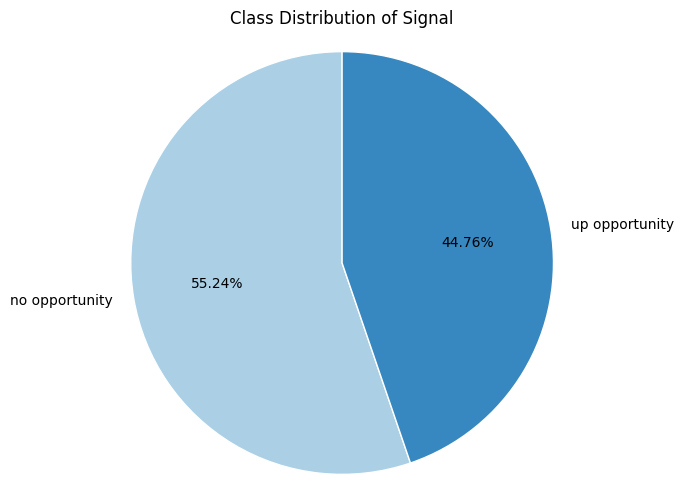

In [ ]:
# Visualize the class distribution
plt.figure(figsize=(6, 6))

colors = sns.color_palette("Blues", len(class_distribution))
class_labels = {0: 'no opportunity', 1: 'up opportunity'}

plt.pie(
    class_distribution,
    labels= [class_labels[i] for i in range(len(class_distribution))],
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title('Class Distribution of Signal')
plt.axis('equal')
plt.show()

Relatively balanced class distribution => Robust for tree-based classifier models

## Feature Stats

In [ ]:
# Categorical attribute
data_final.loc[:,'Day_of_Week'].value_counts()

,count
Day_of_Week,
Wednesday,734
Tuesday,734
Thursday,723
Friday,718
Monday,668


In [ ]:
# Continuous attributes
data_final.loc[:,['Daily_Returns', 'Volume_Change', 'Volatility', 'RSI', 'MA_Ratio']].describe()

,Daily_Returns,Volume_Change,Volatility,RSI,MA_Ratio
count,3577.0000,3577.0000,3577.0000,3577.0000,3577.0000
mean,0.2183,1.4809,3.2238,53.2552,1.0324
std,3.5918,45.0571,1.5674,17.8148,0.1252
min,-21.0628,-83.2239,0.6531,5.1392,0.6763
25%,-1.5748,-25.0113,2.1270,40.4924,0.9500
50%,0.1261,-7.7542,2.8895,53.1860,1.0193
75%,1.9272,14.9965,3.8860,65.9589,1.1011
max,24.3951,551.0873,12.4635,97.5299,1.6224


## Feature Distribution

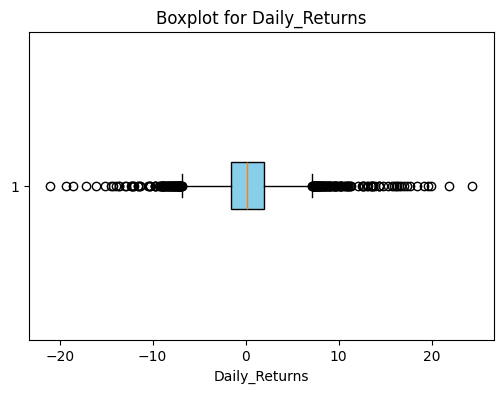

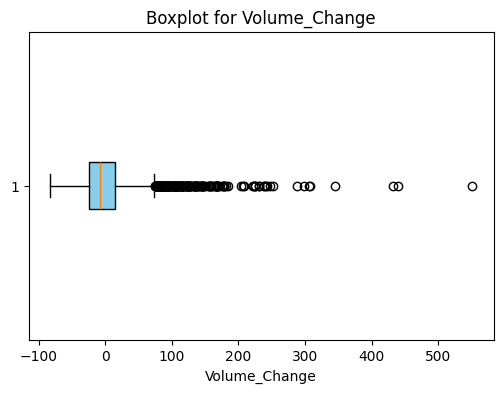

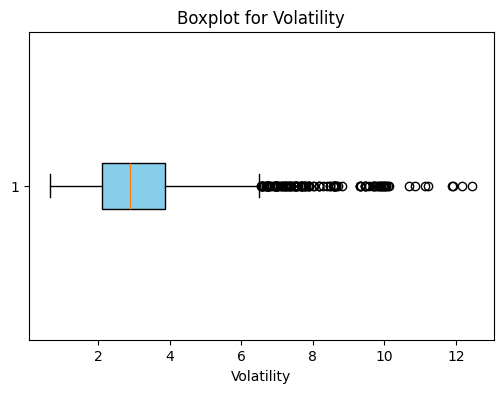

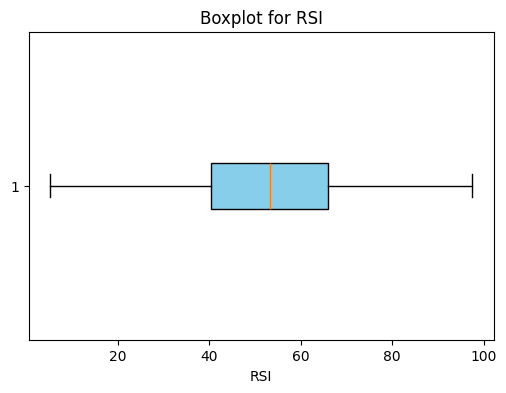

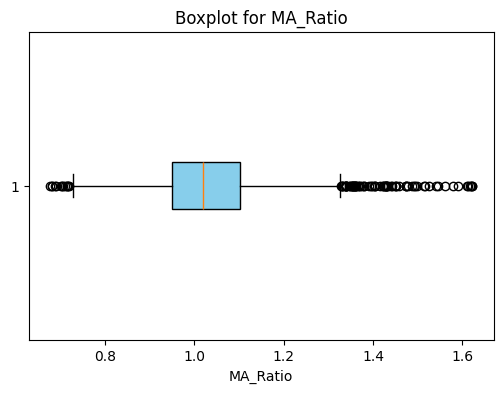

In [ ]:
# Plotting distribution (boxplots) for continuous features

for feature in continuous_predictors:
    plt.figure(figsize=(6, 4))
    plt.boxplot(data[feature], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    plt.title(f'Boxplot for {feature}')
    plt.xlabel(feature)
    plt.show()

Volume_Change, Volatility, and MA_Ratio are positively skewed. Within those, Volume_Change has extreme outliers. However, there's no need to transform to a normal distribution or scaling to MinMax values as we will use tree-based models.

<ipython-input-84-e6058fee1080>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data_final[numeric_cols].resample('M').mean()  # 'M' for monthly resampling


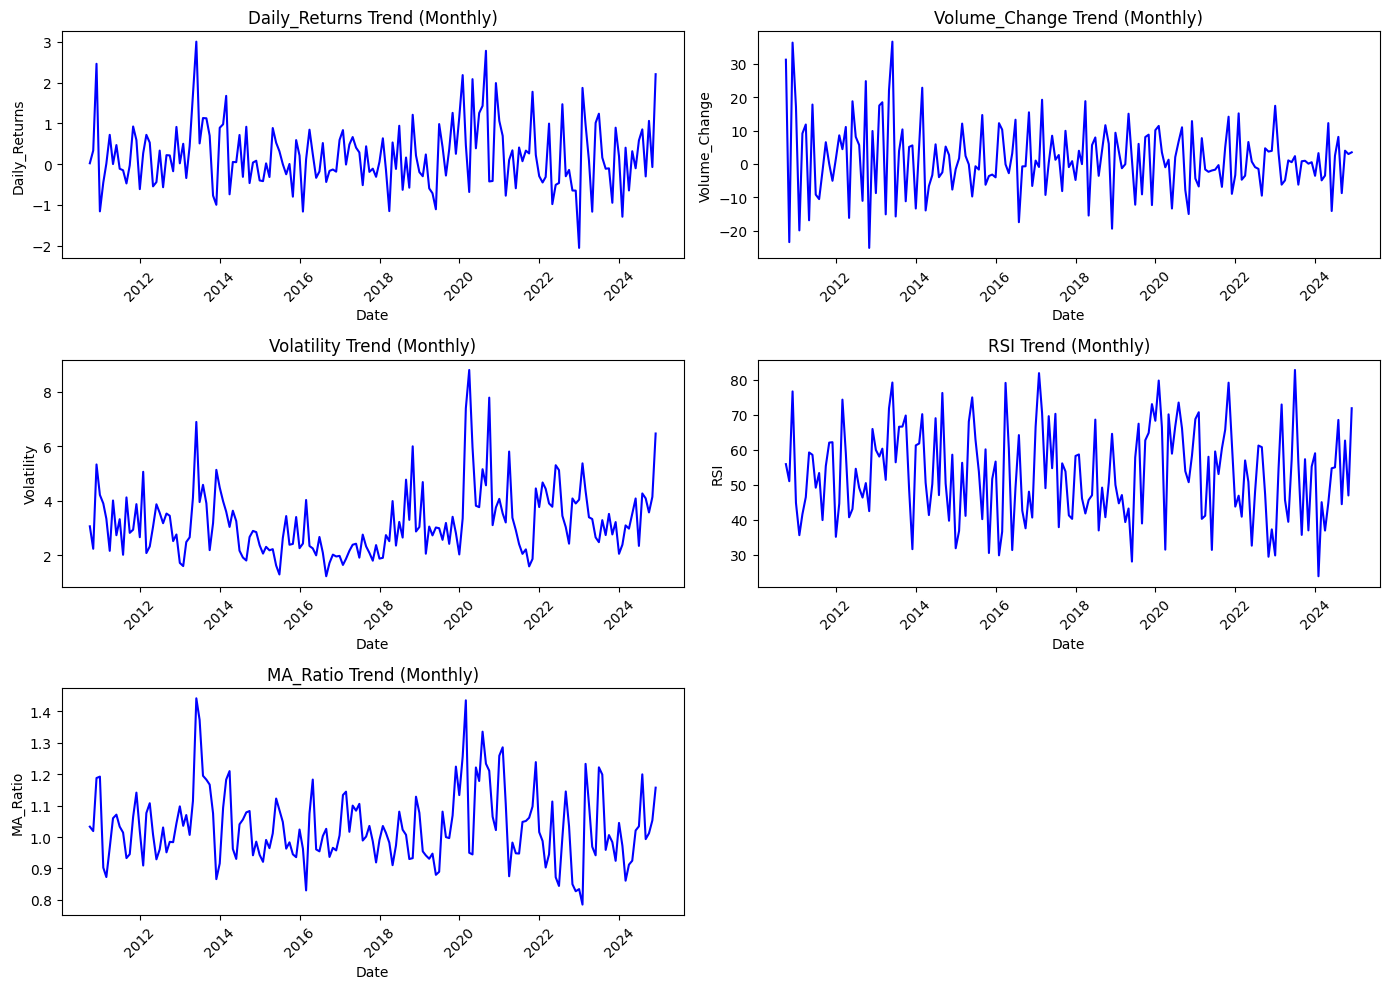

In [ ]:
# Plotting trend for features and the target variable
numeric_cols = ['Daily_Returns', 'Volume_Change', 'Volatility', 'RSI', 'MA_Ratio']
categorical_cols = ['Signal', 'Day_of_Week']

# Resample the data by month (you can also use 'Q' for quarter)
data_monthly = data_final[numeric_cols].resample('M').mean()  # 'M' for monthly resampling

# Plot trend for each variable over time (monthly)


for i, variable in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)  # Create a subplot for each variable
    sns.lineplot(data=data_monthly, x=data_monthly.index, y=variable, color='blue')
    plt.title(f'{variable} Trend (Monthly)')
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


## Correlation

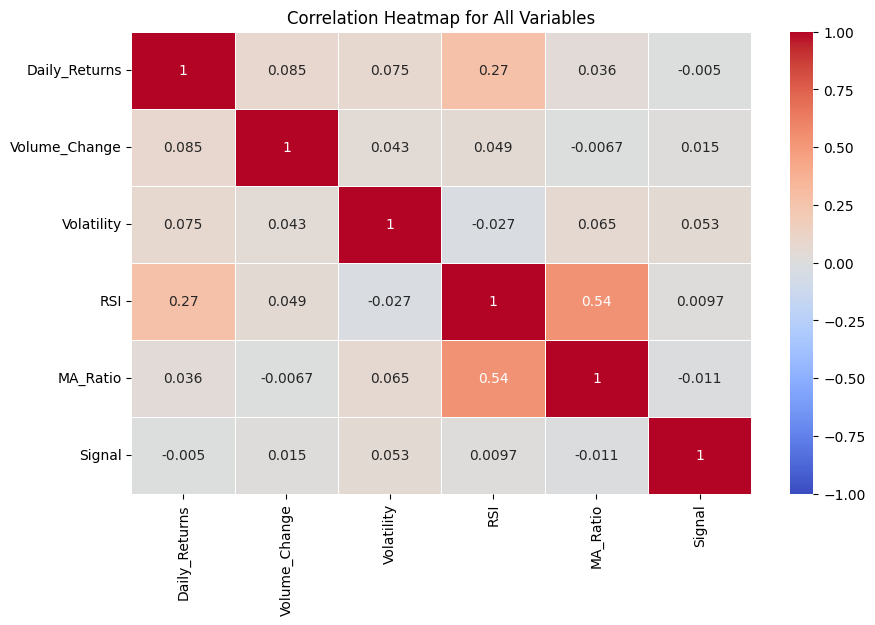

In [ ]:
# Check for Correlation between the target variable and its continuous features
corr_matrix = data_final.loc[:,data_final.columns != 'Day_of_Week'].corr()

plt.figure(figsize=(10,6))

sns.heatmap(corr_matrix, annot=True, cmap= 'coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap for All Variables")
plt.show()

Low correlation between the target variable and features suggests non-linear relationship
=> Use tree-based models

# Classification Models if split randomly

In [ ]:
# Create dummy for Day of Week attribute
data_final = pd.get_dummies(data_final, columns=['Day_of_Week'], drop_first=True)
data_final.head()

,Daily_Returns,Volume_Change,Volatility,RSI,MA_Ratio,Signal,Day_of_Week_Monday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday
Date,,,,,,,,,,
2010-09-08 00:00:00-04:00,1.7527,-31.3170,2.4368,67.1497,1.0220,1,False,False,False,True
2010-09-09 00:00:00-04:00,-0.9090,-7.6107,2.2829,65.0470,1.0294,0,False,True,False,False
2010-09-10 00:00:00-04:00,-2.6074,-3.9432,2.4576,58.0938,1.0353,0,False,False,False,False
2010-09-13 00:00:00-04:00,2.7268,-9.9328,2.5696,54.8124,1.0418,1,True,False,False,False
2010-09-14 00:00:00-04:00,1.9305,66.6836,2.6066,67.1428,1.0461,0,False,False,True,False


In [ ]:
# Split Data into Training and Testing Sets
x = data_final.loc[:,data_final.columns != 'Signal']
y = data_final['Signal']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

The 'stratify' argument has ensured the split keeps the original class distribution

## 1. Decision Tree Model

### without parameter tuning

In [ ]:
# Train the Decision Tree Model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)

# Evaluate the Model
y_pred = clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5633147113594041

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.58      0.60       593
           1       0.51      0.54      0.52       481

    accuracy                           0.56      1074
   macro avg       0.56      0.56      0.56      1074
weighted avg       0.57      0.56      0.56      1074



### with parameter tuning

In [ ]:
# Perform Randomized Search
param_dist = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 11),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']}

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,  # Number of random configurations to try
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model
random_search.fit(x_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 15, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the Model
y_pred = random_search.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5754189944134078

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.84      0.69       593
           1       0.56      0.25      0.35       481

    accuracy                           0.58      1074
   macro avg       0.57      0.54      0.52      1074
weighted avg       0.57      0.58      0.53      1074



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate Stratified Accuracy for Each Class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Display results
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} Accuracy: {acc:.2f}")

Class 0 Accuracy: 0.84
Class 1 Accuracy: 0.25


### feature importance

In [ ]:
# Features Importance
all_predictors = continuous_predictors + list(data_final.columns[data_final.columns.str.startswith('Day_of_Week_')])

feature_importance1 = pd.DataFrame({
    'Feature': all_predictors,
    'Importance': clf.feature_importances_
})
feature_importance1 = feature_importance1.sort_values(by='Importance', ascending=False)
feature_importance1

,Feature,Importance
2,Volatility,0.1985
3,RSI,0.1925
4,MA_Ratio,0.1861
1,Volume_Change,0.1797
0,Daily_Returns,0.1609
5,Day_of_Week_Monday,0.0263
7,Day_of_Week_Tuesday,0.0237
6,Day_of_Week_Thursday,0.0218
8,Day_of_Week_Wednesday,0.0105


## 2. Random Forest Model

### without parameter tuning

In [ ]:
# Train the Random Forest model
forest = RandomForestClassifier(random_state=42)

forest.fit(x_train, y_train)

y_pred2 = forest.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.5595903165735568

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.67      0.63       593
           1       0.51      0.42      0.46       481

    accuracy                           0.56      1074
   macro avg       0.55      0.55      0.54      1074
weighted avg       0.55      0.56      0.55      1074



### with parameter tuning

In [ ]:
# Performance Randomized Search

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

tscv = TimeSeriesSplit(n_splits=5)
random_search2 = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_grid,
    scoring='f1',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search2.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
# Evaluate the model
y_pred2 = random_search2.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))


Accuracy: 0.5726256983240223

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.68      0.64       593
           1       0.53      0.43      0.48       481

    accuracy                           0.57      1074
   macro avg       0.56      0.56      0.56      1074
weighted avg       0.57      0.57      0.57      1074



### feature importance

In [ ]:
feature_importance2 = pd.DataFrame({
    'Feature': all_predictors,
    'Importance': forest.feature_importances_
})
feature_importance2 = feature_importance2.sort_values(by='Importance', ascending=False)
feature_importance2

,Feature,Importance
4,MA_Ratio,0.2079
2,Volatility,0.1907
3,RSI,0.1881
1,Volume_Change,0.1778
0,Daily_Returns,0.1728
8,Day_of_Week_Wednesday,0.0171
7,Day_of_Week_Tuesday,0.0157
6,Day_of_Week_Thursday,0.0153
5,Day_of_Week_Monday,0.0145


## 3. Gradient Boosting Classifier

### without parameter tuning

In [ ]:
# Train the model

gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(x_train, y_train)

# Evaluate the model
y_pred3 = gbt.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("\nClassification Report:\n", classification_report(y_test, y_pred3))

Accuracy: 0.590316573556797

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.78      0.68       593
           1       0.57      0.36      0.44       481

    accuracy                           0.59      1074
   macro avg       0.58      0.57      0.56      1074
weighted avg       0.59      0.59      0.57      1074



### feature importance

<ipython-input-114-830c51620cea>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


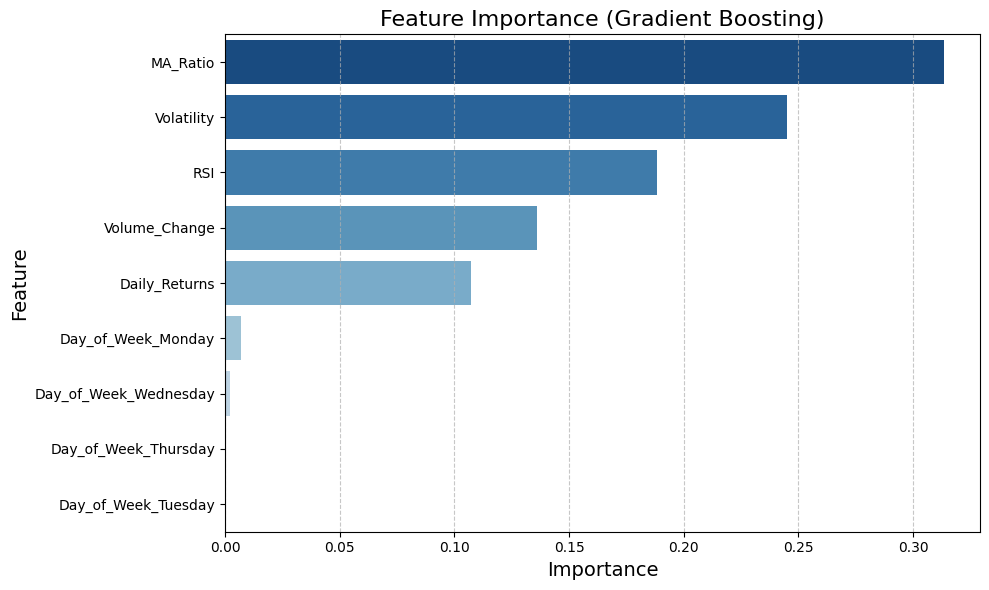

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': all_predictors,
    'Importance': gbt.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance,
    palette='Blues_r'
)

# Customize the plot
plt.title('Feature Importance (Gradient Boosting)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### with paramter tuning

In [ ]:
# Perform Randomized Search CV
param_dist = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [3, 5, 10, None],  # Maximum depth of the individual trees
    'learning_rate': [0.001, 0.01, 0.1],  # Step size
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples used to fit each tree
    'min_samples_split': np.arange(2, 21),  # Minimum samples required to split a node
    'min_samples_leaf': np.arange(1, 11),  # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}


tscv = TimeSeriesSplit(n_splits=5)
random_search3 = RandomizedSearchCV(
    estimator=gbt,
    param_distributions=param_dist,
    n_iter=100,  # Number of random configurations to try
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model
random_search3.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 10, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the model
y_pred3 = random_search3.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("\nClassification Report:\n", classification_report(y_test, y_pred3))

Accuracy: 0.5884543761638734

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.67       593
           1       0.56      0.36      0.44       481

    accuracy                           0.59      1074
   macro avg       0.58      0.57      0.56      1074
weighted avg       0.58      0.59      0.57      1074



# Classification Models if split chronologically

In [ ]:
# Determine the split index based on the chronological split
split_ratio = 0.7  # Use 70% for training
split_index = int(len(data_final) * split_ratio)

# Split x and y into training and testing sets
x_train2 = x.iloc[:split_index, :]
x_test2 = x.iloc[split_index:, :]

y_train2 = y.iloc[:split_index]
y_test2 = y.iloc[split_index:]

In [ ]:
y_train2.value_counts()

,count
Signal,
0,1359
1,1144


In [ ]:
y_test2.value_counts()

,count
Signal,
0,617
1,457


The class distribution for this chrnological split remains relatively balanced to train tree-based models

## 5. Decision Tree Model

### without parameter tuning

In [ ]:
# Train the Decision Tree Model
clf2 = DecisionTreeClassifier(random_state=42)
clf2.fit(x_train2, y_train2)

# Evaluate the Model
y_pred4 = clf2.predict(x_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred4))
print("\nClassification Report:\n", classification_report(y_test2, y_pred4))

Accuracy: 0.49534450651769085

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.46      0.51       617
           1       0.43      0.54      0.48       457

    accuracy                           0.50      1074
   macro avg       0.50      0.50      0.49      1074
weighted avg       0.51      0.50      0.50      1074



### with parameter tuning

In [ ]:
# Perform Randomized Search CV
param_dist = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 11),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']}

tscv = TimeSeriesSplit(n_splits=5)
random_search4 = RandomizedSearchCV(
    estimator=clf2,
    param_distributions=param_dist,
    n_iter=100,  # Number of random configurations to try
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model
random_search4.fit(x_train2, y_train2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 15, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the Model
y_pred4 = random_search4.predict(x_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred4))
print("\nClassification Report:\n", classification_report(y_test2, y_pred4))

Accuracy: 0.5716945996275605

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.87      0.70       617
           1       0.49      0.16      0.25       457

    accuracy                           0.57      1074
   macro avg       0.54      0.52      0.47      1074
weighted avg       0.54      0.57      0.51      1074



## 6. Random Forest Model

### without parameter tuning

In [ ]:
# Train the Random Forest model
forest2 = RandomForestClassifier(random_state=42)

forest2.fit(x_train2, y_train2)

y_pred5 = forest2.predict(x_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred5))
print("\nClassification Report:\n", classification_report(y_test2, y_pred5))

Accuracy: 0.5437616387337058

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.61       617
           1       0.46      0.43      0.44       457

    accuracy                           0.54      1074
   macro avg       0.53      0.53      0.53      1074
weighted avg       0.54      0.54      0.54      1074



### with parameter tuning

In [ ]:
# Perform Randomized Search CV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

tscv = TimeSeriesSplit(n_splits=5)
random_search5 = RandomizedSearchCV(
    estimator=forest2,
    param_distributions=param_grid,
    scoring='f1',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search5.fit(x_train2, y_train2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
# Evaluate the model
y_pred5 = random_search5.predict(x_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred5))
print("\nClassification Report:\n", classification_report(y_test2, y_pred5))

Accuracy: 0.5661080074487895

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.60      0.61       617
           1       0.49      0.52      0.51       457

    accuracy                           0.57      1074
   macro avg       0.56      0.56      0.56      1074
weighted avg       0.57      0.57      0.57      1074



## 7. Gradient Boosting Classifier

### with parameter tuning

In [ ]:
# Train the model
gbt2 = GradientBoostingClassifier(random_state=42)
gbt2.fit(x_train2, y_train2)

# Evaluate the model
y_pred7 = gbt2.predict(x_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred7))
print("\nClassification Report:\n", classification_report(y_test2, y_pred7))

Accuracy: 0.5595903165735568

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.64       617
           1       0.48      0.41      0.44       457

    accuracy                           0.56      1074
   macro avg       0.54      0.54      0.54      1074
weighted avg       0.55      0.56      0.55      1074



### without parameter tuning

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [3, 5, 10, None],  # Maximum depth of the individual trees
    'learning_rate': [0.001, 0.01, 0.1],  # Step size
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples used to fit each tree
    'min_samples_split': np.arange(2, 21),  # Minimum samples required to split a node
    'min_samples_leaf': np.arange(1, 11),  # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}


tscv = TimeSeriesSplit(n_splits=5)
random_search6 = RandomizedSearchCV(
    estimator=gbt2,
    param_distributions=param_dist,
    n_iter=100,  # Number of random configurations to try
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model
random_search6.fit(x_train2, y_train2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 10, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the model
y_pred7 = random_search6.predict(x_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred7))
print("\nClassification Report:\n", classification_report(y_test2, y_pred7))

Accuracy: 0.5707635009310987

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.94      0.72       617
           1       0.47      0.07      0.12       457

    accuracy                           0.57      1074
   macro avg       0.52      0.51      0.42      1074
weighted avg       0.53      0.57      0.46      1074

